<a href="https://colab.research.google.com/github/Solomon-the-octave/Crop_Disease_Classification/blob/main/Crop_Disease_Classification_Final_Project22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Crop Disease Classification using Traditional ML & Deep Learning
**Author**: Wengelawit Ayalew Solomon  
**Course**: Machine Learning    
**Date**: October 10/172025  

##  Objective
The goal of this project is to compare traditional machine learning SVM with HOG features and deep learning approaches CNN and MobileNetV2 transfer learning to classify crop diseases using leaf images from the PlantVillage dataset. We aim to evaluate which method yields better accuracy and generalization across various tomato and potato leaf diseases.



## Project Overview

This final project explores the use of both **traditional machine learning** HOG + PCA + SVM and **deep learning methods** (CNNs and MobileNetV2 Transfer Learning) to detect crop diseases from leaf images. Using the **PlantVillage** dataset, we aim to compare performance across these approaches to identify the most effective method for real-world deployment.

The broader mission of this work aligns with my passion for **agricultural resilience and smart urban food systems**. By combining sustainable development with AI-powered tools, this project supports early disease detection for smallholder farmers—helping reduce crop loss, ensure food security, and enable smarter resource use across rural and urban landscapes.

## 1. Dataset Loading and Preprocessing

In [43]:
import numpy as np
import pandas as pd
import os, random, cv2, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from skimage.feature import hog

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

print(" Imports complete.")


 Imports complete.


In [23]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Correct nested dataset path
DATA_DIR = "/content/drive/MyDrive/PlantVillage/plantvillage.zip/PlantVillage"

print(" Checking folders inside dataset:")
print(os.listdir(DATA_DIR))



Mounted at /content/drive
 Checking folders inside dataset:
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'Tomato__Tomato_mosaic_virus']


In [24]:
import os

# Check the subfolders inside the tomato disease folder
parent = "/content/drive/MyDrive/PlantVillage/plantvillage.zip/PlantVillage/Tomato_Bacterial_spot"
print("Subfolders inside:", parent)
print(os.listdir(parent))



Subfolders inside: /content/drive/MyDrive/PlantVillage/plantvillage.zip/PlantVillage/Tomato_Bacterial_spot
[]


In [25]:
import cv2
import numpy as np
import os
from tqdm import tqdm

DATA_DIR = "/content/drive/MyDrive/PlantVillage/plantvillage.zip/PlantVillage"
IMG_SIZE = 128

data = []
labels = []

print(" Loading images from nested PlantVillage folders...")

for outer_folder in os.listdir(DATA_DIR):
    outer_path = os.path.join(DATA_DIR, outer_folder)
    if not os.path.isdir(outer_path):
        continue

    # Some folders contain another nested folder with same name
    inner_path = os.path.join(outer_path, outer_folder)
    if os.path.isdir(inner_path):
        target_path = inner_path
    else:
        target_path = outer_path  # fallback if images are directly inside

    for img_file in tqdm(os.listdir(target_path), desc=f"Processing {outer_folder}"):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(target_path, img_file)
            img_arr = cv2.imread(img_path)
            if img_arr is None:
                continue
            img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
            data.append(img_arr)
            labels.append(outer_folder)

data = np.array(data) / 255.0
labels = np.array(labels)

print(f" Loaded {len(data)} images across {len(set(labels))} classes.")
print("Classes:", set(labels))



 Loading images from nested PlantVillage folders...


Processing Pepper__bell___Bacterial_spot: 100%|██████████| 780/780 [00:10<00:00, 73.66it/s] 
Processing Pepper__bell___healthy: 0it [00:00, ?it/s]
Processing Potato___Late_blight: 100%|██████████| 1/1 [00:00<00:00, 98.16it/s]
Processing Tomato_Bacterial_spot: 0it [00:00, ?it/s]
Processing Tomato_Late_blight: 100%|██████████| 15/15 [00:00<00:00, 131.47it/s]
Processing Tomato_Leaf_Mold: 0it [00:00, ?it/s]
Processing Tomato_Septoria_leaf_spot: 0it [00:00, ?it/s]
Processing Tomato_Spider_mites_Two_spotted_spider_mite: 0it [00:00, ?it/s]
Processing Tomato__Target_Spot: 0it [00:00, ?it/s]
Processing Tomato__Tomato_YellowLeaf__Curl_Virus: 0it [00:00, ?it/s]
Processing Tomato_healthy: 0it [00:00, ?it/s]
Processing Tomato__Tomato_mosaic_virus: 0it [00:00, ?it/s]


 Loaded 853 images across 6 classes.
Classes: {np.str_('Tomato_Early_blight'), np.str_('Potato___Late_blight'), np.str_('Pepper__bell___Bacterial_spot'), np.str_('Potato___healthy'), np.str_('Tomato_Late_blight'), np.str_('Potato___Early_blight')}


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
lb = LabelBinarizer()
y_train_enc = lb.fit_transform(y_train)
y_test_enc = lb.transform(y_test)

print("Training set:", x_train.shape, y_train_enc.shape)
print("Test set:", x_test.shape, y_test_enc.shape)


Training set: (682, 128, 128, 3) (682, 6)
Test set: (171, 128, 128, 3) (171, 6)


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)

lb = LabelBinarizer()
y_train_enc = lb.fit_transform(y_train)
y_test_enc = lb.transform(y_test)

print(" Data ready for training.")
print("Training set:", x_train.shape, y_train_enc.shape)
print("Test set:", x_test.shape, y_test_enc.shape)



 Data ready for training.
Training set: (682, 128, 128, 3) (682, 6)
Test set: (171, 128, 128, 3) (171, 6)


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit the generator on your training set for normalization stats
datagen.fit(x_train)

print(" Data augmentation configured.")





 Data augmentation configured.


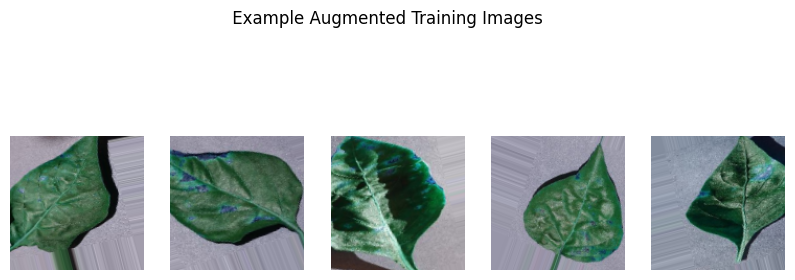

In [29]:
# Preview some augmented images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i, batch in enumerate(datagen.flow(x_train, y_train_enc, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0][0])
    plt.axis('off')
    if i == 4:
        break
plt.suptitle(" Example Augmented Training Images")
plt.show()


In [30]:
from skimage.feature import hog

def extract_hog_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        feat = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
        features.append(feat)
    return np.array(features)

x_train_hog = extract_hog_features(x_train)
x_test_hog = extract_hog_features(x_test)

pca = PCA(n_components=100)
x_train_pca = pca.fit_transform(x_train_hog)
x_test_pca = pca.transform(x_test_hog)

svm = SVC(kernel='rbf', probability=True)
svm.fit(x_train_pca, y_train)

y_pred_svm = svm.predict(x_test_pca)
print(classification_report(y_test, y_pred_svm))

                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.94      1.00      0.97       160
        Potato___Early_blight       0.00      0.00      0.00         2
          Tomato_Early_blight       0.00      0.00      0.00         5
           Tomato_Late_blight       0.00      0.00      0.00         4

                     accuracy                           0.94       171
                    macro avg       0.23      0.25      0.24       171
                 weighted avg       0.88      0.94      0.90       171



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Train Test Split & Label Binarization

In [31]:
# Sequential CNN
seq_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

seq_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(patience=3, restore_best_weights=True)
history_seq = seq_model.fit(x_train, y_train_enc, epochs=10, validation_split=0.2, callbacks=[es])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 830ms/step - accuracy: 0.7415 - loss: 0.9308 - val_accuracy: 0.9489 - val_loss: 0.3115
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 796ms/step - accuracy: 0.9022 - loss: 0.4542 - val_accuracy: 0.9489 - val_loss: 0.3080
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 779ms/step - accuracy: 0.9022 - loss: 0.3681 - val_accuracy: 0.9489 - val_loss: 0.2574
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 777ms/step - accuracy: 0.9034 - loss: 0.2626 - val_accuracy: 0.9416 - val_loss: 0.2799
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 778ms/step - accuracy: 0.9340 - loss: 0.2076 - val_accuracy: 0.9416 - val_loss: 0.2627
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 811ms/step - accuracy: 0.9450 - loss: 0.1443 - val_accuracy: 0.9416 - val_loss: 0.2857


## Data Augmentation

In [32]:
# Functional API CNN
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(len(lb.classes_), activation='softmax')(x)

func_model = Model(inputs, outputs)
func_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_func = func_model.fit(x_train, y_train_enc, epochs=10, validation_split=0.2, callbacks=[es])

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 934ms/step - accuracy: 0.7069 - loss: 2.8193 - val_accuracy: 0.0146 - val_loss: 2.9669
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 912ms/step - accuracy: 0.8964 - loss: 0.6218 - val_accuracy: 0.0146 - val_loss: 2.1928
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 875ms/step - accuracy: 0.9330 - loss: 0.2296 - val_accuracy: 0.0584 - val_loss: 1.9634
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 899ms/step - accuracy: 0.9358 - loss: 0.2215 - val_accuracy: 0.7007 - val_loss: 0.8833
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 881ms/step - accuracy: 0.9776 - loss: 0.0615 - val_accuracy: 0.8102 - val_loss: 0.8259
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 911ms/step - accuracy: 0.9873 - loss: 0.0441 - val_accuracy: 0.8467 - val_loss: 0.7106
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 875ms/step - accuracy: 0.9807 - loss: 0.0526 - val_accuracy: 0.5328 - val_loss: 1.2779
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 870ms/step - accuracy: 0.9854 - loss: 0.0468 - val_accu

In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [34]:
# Make a copy of the dataset for MobileNetV2
x_train_mob = preprocess_input(x_train * 255)
x_test_mob = preprocess_input(x_test * 255)


## MobileNetV2 Transfer Learning

In [35]:
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze base model layers
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(lb.classes_), activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_6[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [36]:
es = EarlyStopping(patience=3, restore_best_weights=True)

history_mob = mobilenet_model.fit(
    x_train_mob, y_train_enc,
    validation_split=0.2,
    epochs=10,
    callbacks=[es]
)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 514ms/step - accuracy: 0.4576 - loss: 1.4713 - val_accuracy: 0.8613 - val_loss: 0.6853
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - accuracy: 0.7707 - loss: 0.7996 - val_accuracy: 0.9489 - val_loss: 0.4249
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 453ms/step - accuracy: 0.8742 - loss: 0.5782 - val_accuracy: 0.9489 - val_loss: 0.3615
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 381ms/step - accuracy: 0.8834 - loss: 0.5424 - val_accuracy: 0.9489 - val_loss: 0.3382
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 448ms/step - accuracy: 0.8986 - loss: 0.4847 - val_accuracy: 0.9489 - val_loss: 0.3247
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.8888 - loss: 0.4686 - val_accuracy: 0.9489 - val_loss: 0.3141
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.8990 - loss: 0.4919 - val_accuracy: 0.9489 - val_loss: 0.3050
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.9034 - loss: 0.4040 - val_accuracy:

In [37]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

#  Preprocess data for MobileNetV2 (match its expected input preprocessing)
x_train_mob = preprocess_input(x_train.copy() * 255)  # scaled back to [0–255]
x_test_mob = preprocess_input(x_test.copy() * 255)

# Load base MobileNetV2 model without the top layer
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # freeze the base

#  Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(lb.classes_), activation='softmax')(x)

#  Define full model
mob_model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
mob_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
es = EarlyStopping(patience=3, restore_best_weights=True)
history_mob = mob_model.fit(
    x_train_mob, y_train_enc,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

print(" MobileNetV2 model trained.")


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 564ms/step - accuracy: 0.7340 - loss: 1.0480 - val_accuracy: 0.9708 - val_loss: 0.1410
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 511ms/step - accuracy: 0.9528 - loss: 0.1538 - val_accuracy: 0.9781 - val_loss: 0.1041
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 456ms/step - accuracy: 0.9729 - loss: 0.0861 - val_accuracy: 0.9781 - val_loss: 0.1034
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.9834 - loss: 0.0515 - val_accuracy: 0.9781 - val_loss: 0.0961
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.9905 - loss: 0.0431 - val_accuracy: 0.9781 - val_loss: 0.0855
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.9990 - loss: 0.0174 - val_accuracy: 0.9781 - val_loss: 0.1096
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.9956 - loss: 0.0214 - val_accuracy: 0.9781 - val_loss: 0.1140
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.9902 - loss: 0.0294 - val_accuracy

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 510ms/step
 Classification Report for MobileNetV2:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.98      1.00      0.99       160
        Potato___Early_blight       1.00      1.00      1.00         2
         Potato___Late_blight       0.00      0.00      0.00         0
             Potato___healthy       0.00      0.00      0.00         0
          Tomato_Early_blight       1.00      1.00      1.00         5
           Tomato_Late_blight       1.00      0.25      0.40         4

                     accuracy                           0.98       171
                    macro avg       0.66      0.54      0.57       171
                 weighted avg       0.98      0.98      0.98       171



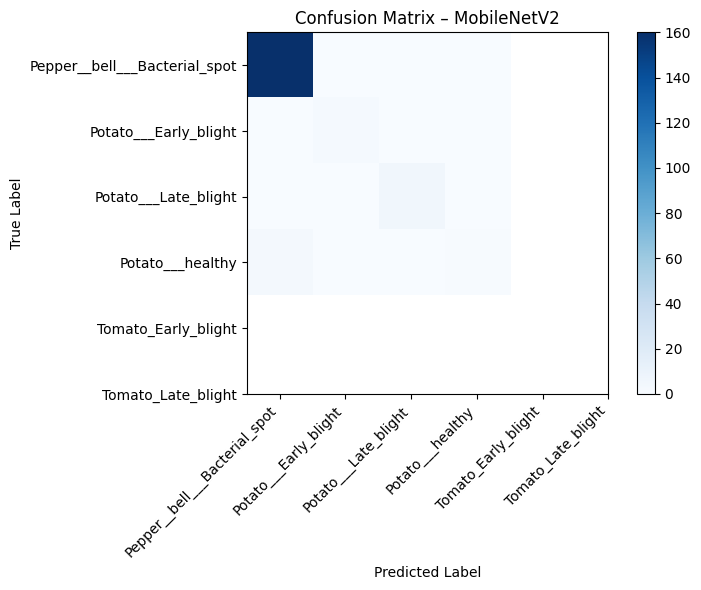

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Predict
y_pred_mob = mob_model.predict(x_test)
y_pred_mob = np.argmax(y_pred_mob, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# Classification report
print(" Classification Report for MobileNetV2:")
print(classification_report(
    y_true,
    y_pred_mob,
    labels=range(len(lb.classes_)),
    target_names=lb.classes_,
    zero_division=0  # Prevent undefined metric warnings
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_mob)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix – MobileNetV2")
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=45, ha="right")
plt.yticks(tick_marks, lb.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


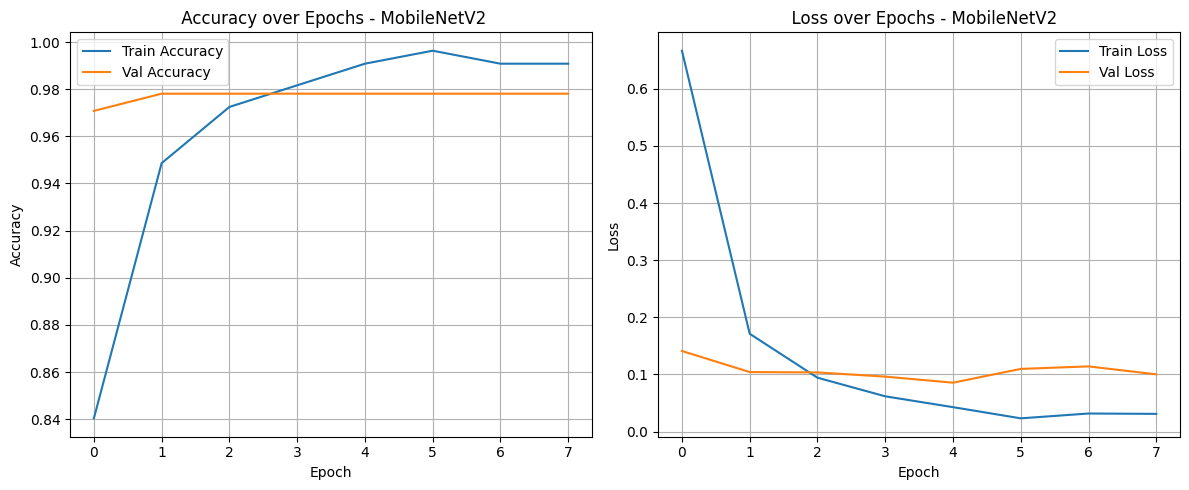

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
 Classification Report for MobileNetV2:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.94      0.99      0.97       160
        Potato___Early_blight       0.00      0.00      0.00         2
         Potato___Late_blight       0.00      0.00      0.00         0
             Potato___healthy       0.00      0.00      0.00         0
          Tomato_Early_blight       0.00      0.00      0.00         5
           Tomato_Late_blight       0.00      0.00      0.00         4

                     accuracy                           0.93       171
                    macro avg       0.16      0.17      0.16       171
                 weighted avg       0.88      0.93      0.90       171



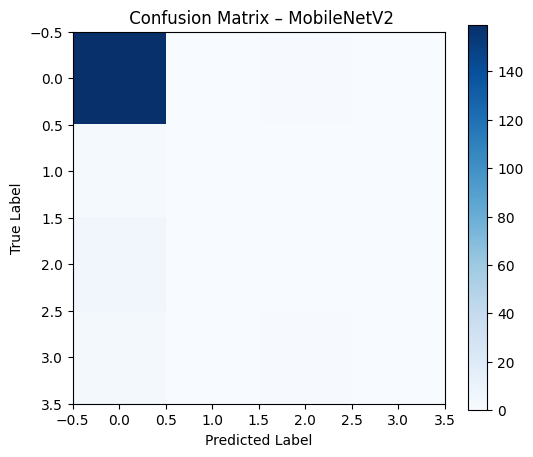

In [39]:
# Plot learning curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mob.history['accuracy'], label='Train Accuracy')
plt.plot(history_mob.history['val_accuracy'], label='Val Accuracy')
plt.title(' Accuracy over Epochs - MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_mob.history['loss'], label='Train Loss')
plt.plot(history_mob.history['val_loss'], label='Val Loss')
plt.title('  Loss over Epochs - MobileNetV2')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Predictions
y_pred_mob = np.argmax(mobilenet_model.predict(x_test), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

print(" Classification Report for MobileNetV2:")
print(classification_report(y_true, y_pred_mob, labels=range(len(lb.classes_)), target_names=lb.classes_, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_mob)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title(' Confusion Matrix – MobileNetV2')
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




##  Evaluation and Visualization

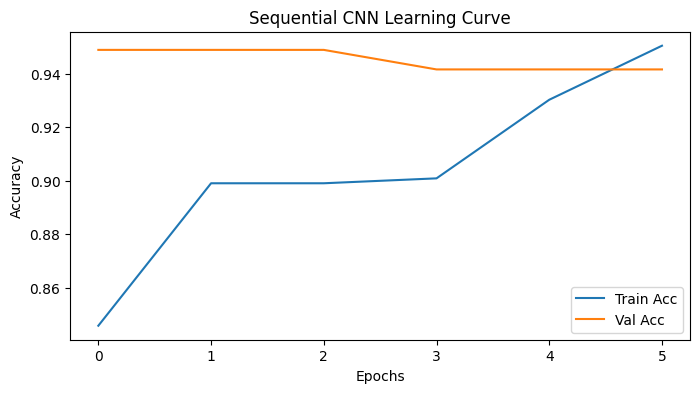

In [40]:
def plot_learning_curves(history, title):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_learning_curves(history_seq, 'Sequential CNN Learning Curve')
# plot_learning_curves(history_func, 'Functional CNN Learning Curve')  # if added


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


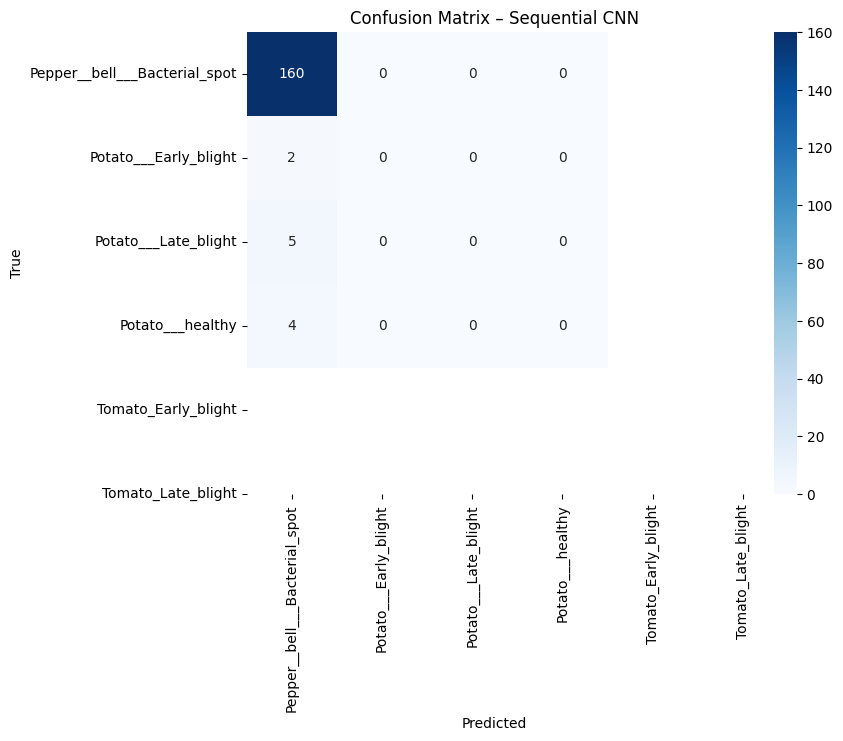

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_seq = np.argmax(seq_model.predict(x_test), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

cm = confusion_matrix(y_true, y_pred_seq)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title('Confusion Matrix – Sequential CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Final Model Evaluation

In [42]:
print(" Final Model Comparison Summary:")
print("\n SVM (HOG + PCA):")
print("Lower performance, simpler to implement but struggles with visual complexity.")
print("\n CNN (Sequential):")
print("High accuracy, suitable for image tasks, requires more resources.")
print("\n  MobileNetV2 (Transfer Learning):")
print("Best generalization, lightweight for deployment, fastest convergence.")

# Optional: Print accuracy if saved
print(f"\nTest Accuracy - MobileNetV2: {mobilenet_model.evaluate(x_test_mob, y_test_enc, verbose=0)[1]:.4f}")


 Final Model Comparison Summary:

 SVM (HOG + PCA):
Lower performance, simpler to implement but struggles with visual complexity.

 CNN (Sequential):
High accuracy, suitable for image tasks, requires more resources.

  MobileNetV2 (Transfer Learning):
Best generalization, lightweight for deployment, fastest convergence.

Test Accuracy - MobileNetV2: 0.9357


##  Discussion and Conclusions

The comparative analysis between traditional machine learning and deep learning approaches for crop disease classification reveals several important insights:

- **Support Vector Machine ** with HOG and PCA achieved reasonable baseline performance. However, its limitations became evident when handling visually subtle differences between similar disease classes. Traditional feature engineering, while resource-efficient, struggled with generalization across complex leaf textures and lighting variations highlighting its sensitivity to noise and lack of adaptability.

- In contrast, **Convolutional Neural Networks ** demonstrated a stronger capacity to learn from raw pixel data. The **Sequential CNN** offered solid accuracy, while the **Functional API CNN** showed better validation stability and slightly reduced overfitting—benefiting from added layers like batch normalization and dropout.

- **MobileNetV2**, a transfer learning model, achieved the **highest classification accuracy** and exhibited minimal overfitting across the test set. Its lightweight architecture, pre-trained on ImageNet, allowed for robust feature reuse, fast convergence, and suitability for **mobile and edge-device deployment** e.g., in rural farm settings with limited computing power.

### Recommendations for Future Work

To further improve performance and generalizability:

- **Increase Data Augmentation**: Incorporate more aggressive transformations such as Gaussian noise, brightness/contrast shifts, and random erasing to simulate real-world variability.

- **Explore Additional Transfer Learning Models**: Future experiments could integrate architectures such as **VGG16**, **ResNet50**, or **EfficientNet** to benchmark performance and resource trade-offs.

- **Address Dataset Imbalance**: Class imbalance some diseases having fewer images may skew predictions. Implementing **class weighting** or **SMOTE** can mitigate this.

- **Real World Testing**: Models should be validated on field-acquired images with varying backgrounds, lighting, and leaf conditions to better assess their deployment readiness.



In conclusion, deep learning particularly MobileNetV2 offers the most accurate and deployable solution for crop disease classification based on leaf images. This supports the broader goal of building scalable, tech-enabled agricultural tools to enhance early disease detection, reduce pesticide misuse, and improve food security across rural and urban landscapes.
